In [1]:
pip install metapy

     |████████████████████████████████| 14.3MB 330kB/s 


In [2]:
!python -V

Python 3.7.10


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import metapy
metapy.__version__
metapy.log_to_stderr()

In [4]:
#Cargar datos a colab desde rive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
!ls -l drive/MyDrive/meta/data/dataset-full-corpus.txt #corpus de documentos

-rw------- 1 root root 214 Mar  7 00:08 drive/MyDrive/meta/data/dataset-full-corpus.txt


In [39]:
!cat drive/MyDrive/meta/data/dataset-full-corpus.txt

class-label 0812.2709.txt
class-label2 0811.2853.txt
class-label3 0811.1254.txt
class-label4 0808.0084.txt
class-label5 0803.2570.txt
class-label6 0710.0736.txt
class-label7 0706.1402.txt
class-label8 0704.3504.txt

In [6]:
import pandas as pd

In [7]:
#Traer los datos desde el repositorio
!wget -nc https://raw.github.com/st1800eafit/st1800_20211/tree/main/datasets/papers_sample_pdf/*.txt

--2021-03-08 17:13:01--  https://raw.github.com/st1800eafit/st1800_20211/tree/main/datasets/papers_sample_pdf/*.txt
Resolving raw.github.com (raw.github.com)... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.github.com (raw.github.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://raw.githubusercontent.com/st1800eafit/st1800_20211/tree/main/datasets/papers_sample_pdf/*.txt [following]
--2021-03-08 17:13:02--  https://raw.githubusercontent.com/st1800eafit/st1800_20211/tree/main/datasets/papers_sample_pdf/*.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 404 Not Found
2021-03-08 17:13:02 ERROR 404: Not Found.



In [8]:
!wget -nc https://raw.github.com/st1800eafit/st1800_20211/tree/main/datasets/papers_sample_pdf/*.xml


--2021-03-08 17:13:04--  https://raw.github.com/st1800eafit/st1800_20211/tree/main/datasets/papers_sample_pdf/*.xml
Resolving raw.github.com (raw.github.com)... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.github.com (raw.github.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://raw.githubusercontent.com/st1800eafit/st1800_20211/tree/main/datasets/papers_sample_pdf/*.xml [following]
--2021-03-08 17:13:04--  https://raw.githubusercontent.com/st1800eafit/st1800_20211/tree/main/datasets/papers_sample_pdf/*.xml
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 404 Not Found
2021-03-08 17:13:04 ERROR 404: Not Found.



Creación del corpus


In [9]:
import glob
import re
filenames = glob.glob("drive/MyDrive/meta/data/*.txt")
corpus_per_document = []
corpus = ""
for f in filenames:
  doc_corpus = open(f, "r").read()
  corpus += doc_corpus
  corpus_per_document.append(doc_corpus)

filename_xml = glob.glob("drive/MyDrive/meta/data/*.xml")
xml_file = open(filename_xml[0], "r").read()
xml_file = re.sub('<[^>]*>', "", xml_file)
doc_corpus += xml_file
corpus_per_document.append(xml_file)  

Tokenización


In [15]:
doc = metapy.index.Document()
tok = metapy.analyzers.ICUTokenizer()
tok = metapy.analyzers.LowercaseFilter(tok)
def split(r):
    tok.set_content(r)
    lista = [t for t in tok]
    return lista[1:-1]

In [16]:
#Si queremos eliminar de entrada caracteres no deseados
doc.content(corpus)
tok = metapy.analyzers.LengthFilter(tok, min=2, max=30)
tok.set_content(doc.content())
tokens = [token for token in tok]
print(tokens[0:20])

['<s>', 'smooth', 'rényi', 'entropy', 'of', 'ergodic', 'quantum', 'information', 'sources', 'berry', 'schoenmakers', 'jilles', 'tjoelker', 'arxiv', '0704.3504v1', 'quant', 'ph', '26', 'apr', '2007']


In [17]:
#Podemos pasar toda a minuscula
tok = metapy.analyzers.ICUTokenizer(suppress_tags=True)
tok = metapy.analyzers.LowercaseFilter(tok)
tok.set_content(doc.content())
tokens = [token for token in tok]
print(tokens[0:20])

['smooth', 'rényi', 'entropy', 'of', 'ergodic', 'quantum', 'information', 'sources', 'berry', 'schoenmakers', 'jilles', 'tjoelker', 'arxiv', ':', '0704.3504v1', '[', 'quant', '-', 'ph', ']']


In [18]:
!wget -nc https://raw.githubusercontent.com/meta-toolkit/meta/master/data/lemur-stopwords.txt

--2021-03-08 17:28:43--  https://raw.githubusercontent.com/meta-toolkit/meta/master/data/lemur-stopwords.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2747 (2.7K) [text/plain]
Saving to: ‘lemur-stopwords.txt’

lemur-stopwords.txt 100%[===================>]   2.68K  --.-KB/s    in 0s      

2021-03-08 17:28:44 (56.7 MB/s) - ‘lemur-stopwords.txt’ saved [2747/2747]



In [19]:
import nltk
#Si queremos especificar por parametro 
doc.content(corpus)
tok = metapy.analyzers.ICUTokenizer()

#Eliminamos los terminos que no nos interesan
tok = metapy.analyzers.ListFilter(tok, "lemur-stopwords.txt", metapy.analyzers.ListFilter.Type.Reject)
tok.set_content(doc.content())
tokens = [token for token in tok]



Stemming

In [20]:
tok = metapy.analyzers.Porter2Filter(tok)
tok.set_content(doc.content())
tokens = [token for token in tok]

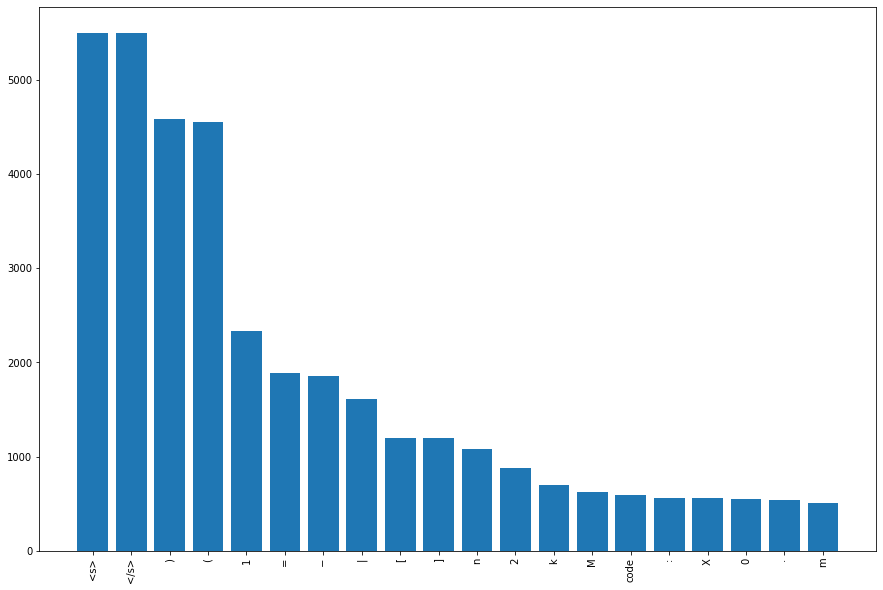

['<s>', 'Smooth', 'Rényi', 'Entropi', 'Ergodic', 'Quantum', 'Informat', 'Sourc', 'Berri', 'Schoenmak', 'Jill', 'Tjoelker', 'arXiv', ':', '0704.3504v1', '[', 'quant', 'ph', ']', '26']


In [25]:
#Uso de nltk
fdist = nltk.FreqDist(tokens)
topwords = fdist.most_common(20)
x,y = zip(*topwords)
plt.figure(figsize=(15,10))
plt.bar(x,y)
plt.xticks(rotation=90)
plt.show()
print(tokens[0:20])

#print(len(set(tokens)))

**Histograma top tokens**

In [ ]:
ana = metapy.analyzers.load('drive/MyDrive/meta/dataset-config.toml')
doc = metapy.index.Document()
doc.content(corpus)
df = pd.DataFrame(ana.analyze(doc).items(), columns=["word", "count"])

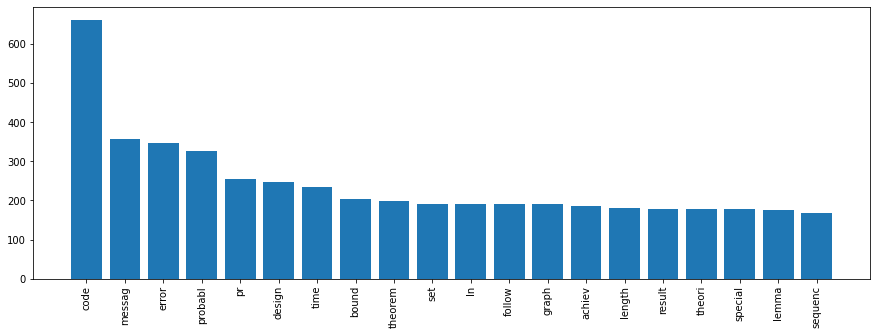

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
#Top 20 tokens
df_print = df.sort_values("count", ascending=False)[0:20]
plt.figure(figsize=(15,5))     
plt.xticks(rotation=90)       
plt.bar(df_print["word"], df_print["count"])
plt.show()

Tokeniazación adicional

**Bow**

In [ ]:
#Unigram
inv_idx = metapy.index.make_inverted_index('drive/MyDrive/meta/dataset-config.toml')


1615206671: [info]     Loading index from disk: dataset-unigram-idx/inv (/tmp/pip-req-build-rzvoxums/deps/meta/src/index/inverted_index.cpp:171)


In [ ]:
inv_idx.unique_terms()

3534

In [ ]:
#Bigram
inv_idx_bigram = metapy.index.make_inverted_index('drive/MyDrive/meta/dataset-config-bigram.toml')

1615206694: [info]     Creating index: dataset-bigram-idx/inv (/tmp/pip-req-build-rzvoxums/deps/meta/src/index/inverted_index.cpp:119)
 > Tokenizing Docs: [========================================] 100% ETA 00:00:00 
 > Merging: [================================================] 100% ETA 00:00:00 
1615206694: [info]     Created uncompressed postings file dataset-bigram-idx/inv/postings.index (609.760000 KB) (/tmp/pip-req-build-rzvoxums/deps/meta/src/index/inverted_index.cpp:148)
 > Compressing postings: [===================================] 100% ETA 00:00:00 
1615206694: [info]     Created compressed postings file (186.300000 KB) (/tmp/pip-req-build-rzvoxums/deps/meta/src/index/inverted_index.cpp:279)
1615206694: [info]     Done creating index: dataset-bigram-idx/inv (/tmp/pip-req-build-rzvoxums/deps/meta/src/index/inverted_index.cpp:166)


In [ ]:
inv_idx_bigram.unique_terms()

41600

In [ ]:
#trigram
inv_idx_trigram = metapy.index.make_inverted_index('drive/MyDrive/meta/dataset-config-trigram.toml')

1615206646: [info]     Creating index: dataset-trigram-idx/inv (/tmp/pip-req-build-rzvoxums/deps/meta/src/index/inverted_index.cpp:119)
 > Tokenizing Docs: [========================================] 100% ETA 00:00:00 
 > Merging: [================================================] 100% ETA 00:00:00 
1615206646: [info]     Created uncompressed postings file dataset-trigram-idx/inv/postings.index (1.370000 MB) (/tmp/pip-req-build-rzvoxums/deps/meta/src/index/inverted_index.cpp:148)
 > Compressing postings: [===================================] 100% ETA 00:00:00 
1615206647: [info]     Created compressed postings file (327.740000 KB) (/tmp/pip-req-build-rzvoxums/deps/meta/src/index/inverted_index.cpp:279)
1615206647: [info]     Done creating index: dataset-trigram-idx/inv (/tmp/pip-req-build-rzvoxums/deps/meta/src/index/inverted_index.cpp:166)


In [ ]:
inv_idx_trigram.unique_terms()

80586

**Representación de características**

In [ ]:
fidx = metapy.index.make_forward_index('drive/MyDrive/meta/dataset-config.toml')

1615206650: [info]     Loading index from disk: dataset-unigram-idx/fwd (/tmp/pip-req-build-rzvoxums/deps/meta/src/index/forward_index.cpp:171)


In [ ]:
tok = metapy.analyzers.Porter2Filter(tok)
for i in range(0,fidx.unique_terms()):
  tok.set_content(fidx.term_text(i))
  [token for token in tok]

In [ ]:
dset = metapy.learn.Dataset(fidx)

 > Loading instances into memory: [==========================] 100% ETA 00:00:00 


In [ ]:
lda_inf = metapy.topics.LDACollapsedVB(dset, num_topics=2, alpha=1.0, beta=0.01)
lda_inf.run(num_iters=1000)

Initialization: [============================================] 100% ETA 00:00:00 
Iteration 1 maximum change in gamma: 1.9669                                     
Iteration 2 maximum change in gamma: 0.368008                                   
Iteration 3 maximum change in gamma: 0.794292                                   
Iteration 4 maximum change in gamma: 1.14811                                    
Iteration 5 maximum change in gamma: 1.13472                                    
Iteration 6 maximum change in gamma: 0.936353                                   
Iteration 7 maximum change in gamma: 0.984288                                   
Iteration 8 maximum change in gamma: 0.972697                                   
Iteration 9 maximum change in gamma: 1.01472                                    
Iteration 10 maximum change in gamma: 0.894503                                  
Iteration 11 maximum change in gamma: 0.917434                                  
Iteration 12 maximum change

In [ ]:
lda_inf.save('lda-cvb0')

In [ ]:
model = metapy.topics.TopicModel('lda-cvb0')#Configuración del modelo

 > Loading topic term probabilities: [=======================] 100% ETA 00:00:00 
 > Loading document topic probabilities: [===================] 100% ETA 00:00:00 


In [ ]:
model.top_k(tid=0)#Top tokens por id

[(1257, 0.013251360960170929),
 (1277, 0.010318889706824002),
 (1706, 0.010315128668484682),
 (2431, 0.009965525335965585),
 (1420, 0.009753257661732797),
 (2448, 0.008089861114259479),
 (2273, 0.008079598963500507),
 (894, 0.008053481498260396),
 (2342, 0.007897888384320437),
 (96, 0.007854607790106088)]

In [ ]:
[(fidx.term_text(pr[0]), pr[1]) for pr in model.top_k(tid=0)] #top tokens por palabras

[('graph', 0.013251360960170929),
 ('gt', 0.010318889706824002),
 ('lemma', 0.010315128668484682),
 ('quantum', 0.009965525335965585),
 ('ij', 0.009753257661732797),
 ('random', 0.008089861114259479),
 ('pn', 0.008079598963500507),
 ('edg', 0.008053481498260396),
 ('probabl', 0.007897888384320437),
 ('algorithm', 0.007854607790106088)]

In [ ]:
model.top_k(tid=1) # Cuando se remuevan las palabras no deseadas esto debería retornar los otros 10 tokens id diferentes

[(525, 0.027708392873036846),
 (1868, 0.015143515595473396),
 (1002, 0.014142366770312198),
 (2306, 0.010463520922122573),
 (756, 0.009751388680524616),
 (2342, 0.009156812840455027),
 (1751, 0.008166447033053387),
 (29, 0.007759678372737313),
 (2818, 0.007419659466083328),
 (1061, 0.006848678758481536)]

In [ ]:
[(fidx.term_text(pr[0]), pr[1]) for pr in model.top_k(tid=1)] # Cuando se remuevan deberían ser palabras diferentes

[('code', 0.027708392873036846),
 ('messag', 0.015143515595473396),
 ('error', 0.014142366770312198),
 ('pr', 0.010463520922122573),
 ('design', 0.009751388680524616),
 ('probabl', 0.009156812840455027),
 ('ln', 0.008166447033053387),
 ('achiev', 0.007759678372737313),
 ('special', 0.007419659466083328),
 ('expon', 0.006848678758481536)]

TF-IDF

In [ ]:
scorer = metapy.topics.BLTermScorer(model)
[(fidx.term_text(pr[0]), pr[1]) for pr in model.top_k(tid=0, scorer=scorer)]

[('gt', 0.052020789357897224),
 ('quantum', 0.050054574969901955),
 ('ij', 0.04742659766464752),
 ('anita', 0.03265466807850015),
 ('edg', 0.03211223783864625),
 ('graph', 0.03192704113747613),
 ('μi', 0.029412834160455148),
 ('randgraph', 0.024959083785275116),
 ('cot', 0.022403660210237097),
 ('cycl', 0.022034638842852616)]

In [ ]:
[(fidx.term_text(pr[0]), pr[1]) for pr in model.top_k(tid=1, scorer=scorer)]

[('messag', 0.07389784106339325),
 ('code', 0.04998702090077245),
 ('ln', 0.0330032488448353),
 ('expon', 0.030045667730602243),
 ('decod', 0.029583174358098097),
 ('τδ', 0.028363138990579406),
 ('block', 0.026139888838226266),
 ('codeword', 0.025789429939358066),
 ('bit', 0.02347694689104296),
 ('feedback', 0.023241359879381807)]

Representación de características con BM25

In [ ]:
ranker = metapy.index.OkapiBM25()

In [ ]:
query = metapy.index.Document()#para histograma
for pr in model.top_k(tid=0):
  query.content(fidx.term_text(pr[0]))
  print(query.content())
  top_docs = ranker.score(inv_idx, query, num_results=8)
  print(top_docs)
for pr in model.top_k(tid=1):
  query.content(fidx.term_text(pr[0]))
  print(query.content())
  top_docs = ranker.score(inv_idx, query, num_results=8)
  print(top_docs)

graph
[(1, 2.0599446296691895), (3, 1.882073163986206), (2, 1.7060130834579468)]
gt
[(1, 3.901857376098633)]
lemma
[(1, 0.7043426632881165), (3, 0.6933962106704712), (7, 0.6930688619613647), (0, 0.6369088292121887), (4, 0.6243201494216919), (2, 0.6211756467819214)]
quantum
[(3, 2.7899491786956787), (7, 2.773345470428467)]
ij
[(1, 2.7873921394348145), (2, 1.1158230304718018)]
random
[(1, 0.39453187584877014), (0, 0.3762381970882416), (3, 0.3712560832500458), (4, 0.3672690987586975), (7, 0.3347156345844269), (6, 0.23482684791088104), (5, 0.20886443555355072)]
pn
[(1, 1.4988367557525635), (0, 1.4683834314346313), (7, 1.4628888368606567), (3, 1.0033135414123535)]
edg
[(1, 1.5028690099716187), (5, 1.3222490549087524), (3, 1.2103097438812256), (2, 0.8651173114776611)]
probabl
[(0, 0.3963400721549988), (4, 0.39378708600997925), (7, 0.39164984226226807), (1, 0.389066606760025), (3, 0.3890521824359894), (6, 0.23482684791088104), (5, 0.20886443555355072)]
algorithm
[(3, 0.393510639667511), (1, 0

# Representación con PivotedLength

In [ ]:
ranker2 = metapy.index.PivotedLength()

In [ ]:
query = metapy.index.Document()#para histograma
for pr in model.top_k(tid=0):
  query.content(fidx.term_text(pr[0]))
  print(query.content())
  top_docs = ranker2.score(inv_idx, query, num_results=8)
  print(top_docs)
for pr in model.top_k(tid=1):
  query.content(fidx.term_text(pr[0]))
  print(query.content())
  top_docs = ranker2.score(inv_idx, query, num_results=8)
  print(top_docs)

graph
[(1, 2.4959309101104736), (3, 2.1492269039154053), (2, 1.8323233127593994)]
gt
[(1, 4.688180923461914)]
lemma
[(7, 0.8870027661323547), (3, 0.8423556089401245), (1, 0.8263553380966187), (0, 0.7169183492660522), (2, 0.6660273671150208), (4, 0.6150418519973755)]
quantum
[(7, 3.742673397064209), (3, 3.6266627311706543)]
ij
[(1, 3.3385066986083984), (2, 1.1944758892059326)]
random
[(1, 0.4631336033344269), (0, 0.4351902902126312), (3, 0.42917928099632263), (7, 0.36675089597702026), (4, 0.3622496724128723), (6, 0.20465096831321716), (5, 0.19435755908489227)]
pn
[(7, 1.8357775211334229), (1, 1.7534276247024536), (0, 1.7472476959228516), (3, 1.097162127494812)]
edg
[(1, 1.7734582424163818), (5, 1.4981034994125366), (3, 1.343800663948059), (2, 0.9867534041404724)]
probabl
[(7, 0.5138328075408936), (0, 0.5044103860855103), (3, 0.47429904341697693), (1, 0.44241049885749817), (4, 0.41105329990386963), (6, 0.20465096831321716), (5, 0.19435755908489227)]
algorithm
[(3, 0.49339497089385986), (

Implementación con solo un archivo


In [29]:
input_file = open("drive/MyDrive/meta/data/0704.3504.txt", "r")
filedata = input_file.read()

In [33]:
doc2 = metapy.index.Document()
doc2.content(filedata)
#doc2.content(all_content)
tok2 = metapy.analyzers.ICUTokenizer()
tok2 = metapy.analyzers.LowercaseFilter(tok2)
tok2 = metapy.analyzers.ListFilter(tok2, "lemur-stopwords.txt", metapy.analyzers.ListFilter.Type.Reject)
tok2.set_content(doc2.content())

In [47]:
ana = metapy.analyzers.NGramWordAnalyzer(2, tok2)
bigrams = ana.analyze(doc2)

In [49]:
#tok = metapy.analyzers.CharacterTokenizer()
ana = metapy.analyzers.NGramWordAnalyzer(3, tok2)
trigrams = ana.analyze(doc2)

In [ ]:
print(len(unigrams))

632


In [ ]:
print(len(bigrams))

2332


In [ ]:
print(len(trigrams))

2418


In [ ]:
print(type(ngrams))

<class 'dict'>


In [ ]:
import operator
sorted_x = sorted(ngrams.items(), key=operator.itemgetter(0),reverse=True)

In [ ]:
print(sorted_x[0:20])

[(('⊗', 'n', 'are'), 1), (('⊗', 'n', ')'), 1), (('≥', 'μm', 'and'), 1), (('≥', 'μm', ','), 1), (('≥', 'μi', 'for'), 1), (('≥', 'μ2', '≥'), 2), (('≥', 'λm', '.'), 1), (('≥', 'λ2', '≥'), 1), (('≥', '|', 'tǫ'), 1), (('≥', 'n', '('), 5), (('≥', 'max', 'q'), 1), (('≥', 'h2ǫ', '0'), 1), (('≥', 'h02ǫ', '('), 1), (('≥', 'h', '('), 1), (('≥', 'en', '('), 1), (('≥', 'e', '−'), 2), (('≥', '1', '−'), 18), (('≥', '0', 'for'), 1), (('≥', '0', ','), 1), (('≥', '.', '.'), 3), (('≤', '∞', '.'), 5), (('≤', 'σ', '≤'), 5), (('≤', 'ρ', '}'), 4), (('≤', 'ρ', '.'), 1), (('≤', 'ρ', ','), 1), (('≤', 'μi', '≤'), 2), (('≤', 'λi', '≤'), 1), (('≤', 'λi', '}'), 1), (('≤', 'λi', ','), 1), (('≤', 'λi', '('), 1), (('≤', 'α', '<'), 5), (('≤', 'ǫ', '}'), 2), (('≤', 'ǫ', 'z'), 1), (('≤', 'ǫ', 'sup'), 1), (('≤', 'ǫ', '('), 1), (('≤', '|', 'tǫ'), 1), (('≤', 'sup', 'hα'), 1), (('≤', 'q', '('), 5), (('≤', 'p', '('), 8), (('≤', 'n', '('), 3), (('≤', 'inf', 'hα'), 1), (('≤', 'hǫ0', '('), 1), (('≤', 'hǫ', '∞'), 1), (('≤', 'h0ǫ'